# SVM

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Зададим нужные константы для обучения:

In [11]:
# we perform T*Q-fold cross validation (T*Q-fold CV)
T = 3  # number of performing cross validations
Q = 5  # number of folds
SCORING = 'accuracy'

Загрузим подготовленные данные:

In [12]:
from sklearn.externals import joblib

X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

# X_train = joblib.load('../tmp/1467_X_train.pkl')
# y_train = joblib.load('../tmp/1467_y_train.pkl')

display(X_train)

,DIRECTORY_ENTRY_BOUND_IMPORT/exists,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_EXPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOSStub/zeros,DOS_HEADER.e_cblp,...,SECTIONS/entry_point_in_last_section,SECTIONS/entry_point_in_writeable_section,SECTIONS/executable_sections,SECTIONS/max_section_entropy,SECTIONS/rsrc_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections
26682,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.569661,-0.572900,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.377887,0.548801,0.258948,0.546524,-0.460900,-0.288560,-0.094187
50916,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.373237,-0.234648,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.444852,0.051442,0.258948,0.525452,-0.460900,-0.288560,-0.094187
29258,-0.145786,-0.079078,-0.150130,-0.304439,-0.078087,0.333973,-0.507212,0.333303,-0.542699,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.268217,-0.186286,-0.665014,0.581034,-0.460900,-0.288560,-0.094187
18211,-0.145786,0.129710,1.233757,-0.304439,0.712365,0.333973,-0.507212,0.630445,-0.682722,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.252136,0.204942,-0.665014,0.586095,-0.460900,-0.288560,-0.655287
31183,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.467182,-0.191413,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.383324,0.548744,0.258948,0.544813,-0.460900,-0.288560,-0.094187
54395,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,-2.994258,-0.507212,0.333303,-0.542699,-0.011388,...,4.395228,-0.452174,0.569053,0.459248,-2.024843,0.258948,0.809948,0.131280,0.518246,1.028014
27351,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.421855,-0.309327,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.335065,0.369694,0.258948,0.559999,-0.460900,-0.288560,-0.094187
27791,-0.145786,-0.079078,8.845135,3.284733,1.601623,0.333973,1.971561,-1.770532,1.874648,-0.102259,...,-0.227519,-0.452174,0.569053,0.242980,1.187646,1.182910,0.534680,-0.460900,-0.288560,1.589115
19336,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.629202,-0.599746,-0.011388,...,-0.227519,-0.452174,-0.269120,1.378243,0.986296,0.258948,0.562126,-0.460900,-0.288560,-0.094187
27617,-0.145786,0.547286,-0.150130,-0.304439,-0.374507,0.333973,-0.507212,0.611762,-0.664942,-0.011388,...,-0.227519,-0.452174,-0.269120,-1.062610,-0.885523,-0.665014,0.331061,-0.460900,-0.288560,-0.655287


Функция для тестирования кдассификатора:

In [13]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix


def test_classifier(classifier, X, y):
    tns, fps, fns, tps = ([], [], [], [])

    rkf = RepeatedKFold(n_splits=Q, n_repeats=T, random_state=398)
    for train_index, test_index in rkf.split(X):
        curr_X_train, curr_X_test = X.iloc[train_index], X.iloc[test_index]
        curr_y_train, curr_y_test = y.iloc[train_index], y.iloc[test_index]
        classifier.fit(curr_X_train, curr_y_train)
        curr_y_pred = classifier.predict(curr_X_test)
        curr_tn, curr_fp, curr_fn, curr_tp = (
            confusion_matrix(curr_y_test, curr_y_pred).ravel()
        )

        curr_test_size = curr_tn + curr_fp + curr_fn + curr_tp
        assert(curr_test_size == len(curr_X_test)
                   and curr_test_size == len(curr_y_test))
        tns.append({
            'tn': curr_tn,
            'test_size': curr_test_size,
            'tn_rate': curr_tn/curr_test_size,
        })
        fps.append({
            'fp': curr_fp,
            'test_size': curr_test_size,
            'fp_rate': curr_fp/curr_test_size,
        })
        fns.append({
            'fn': curr_fn,
            'test_size': curr_test_size,
            'fn_rate': curr_fn/curr_test_size,
        })
        tps.append({
            'tp': curr_tp,
            'test_size': curr_test_size,
            'tp_rate': curr_tp/curr_test_size,
        })

    tns_df = pd.DataFrame(tns)
    fps_df = pd.DataFrame(fps)
    fns_df = pd.DataFrame(fns)
    tps_df = pd.DataFrame(tps)
    return (tns_df, fps_df, fns_df, tps_df)

Построение графика:

In [14]:
def make_plot(accuracies, deviations, C_tuple, kernel):
    assert(len(accuracies) == len(deviations))
    plt.figure(figsize=(20, 12))
    
    upper = []
    lower = []
    for i in range(len(accuracies)):
        upper.append(accuracies[i] + deviations[i])
        lower.append(accuracies[i] - deviations[i])
    plt.fill_between(
        C_tuple,
        upper,
        lower,
        alpha=0.2,
        color='steelblue',
        lw=1
    )
    
    # plt.grid(True)
    plt.xscale('log')
    plt.ylim([0.50, 1.00])
    plt.xlabel('C', fontsize=32)
    plt.ylabel(SCORING, fontsize=32)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=32)
    ax.tick_params(axis='both', which='minor', labelsize=32)
    plt.plot(C_tuple, accuracies, color='blue', marker='o')
    plt.savefig(
        '../results/svm/kernels/{0}.svg'.format(kernel),
        format='svg',
        dpi=72
    )

Теперь подберём параметры модели:

curr_C = 0.01 ; curr_avg_accuracy = 0.744367310835 ; curr_kernel = rbf
curr_C = 0.05 ; curr_avg_accuracy = 0.810386872044 ; curr_kernel = rbf
curr_C = 0.1 ; curr_avg_accuracy = 0.820998609234 ; curr_kernel = rbf
curr_C = 0.5 ; curr_avg_accuracy = 0.838758020422 ; curr_kernel = rbf
curr_C = 1 ; curr_avg_accuracy = 0.846719134616 ; curr_kernel = rbf
curr_C = 5 ; curr_avg_accuracy = 0.870684700243 ; curr_kernel = rbf
curr_C = 10 ; curr_avg_accuracy = 0.878508626471 ; curr_kernel = rbf
curr_C = 50 ; curr_avg_accuracy = 0.892831316564 ; curr_kernel = rbf
curr_C = 100 ; curr_avg_accuracy = 0.897218570573 ; curr_kernel = rbf


/home/artem/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


curr_C = 500 ; curr_avg_accuracy = 0.906185069807 ; curr_kernel = rbf
curr_C = 1000 ; curr_avg_accuracy = 0.909466405786 ; curr_kernel = rbf
curr_C = 5000 ; curr_avg_accuracy = 0.916047393952 ; curr_kernel = rbf
curr_C = 10000.0 ; curr_avg_accuracy = 0.915096837226 ; curr_kernel = rbf
curr_C = 50000.0 ; curr_avg_accuracy = 0.784154416457 ; curr_kernel = rbf
curr_C = 100000.0 ; curr_avg_accuracy = 0.716809765573 ; curr_kernel = rbf


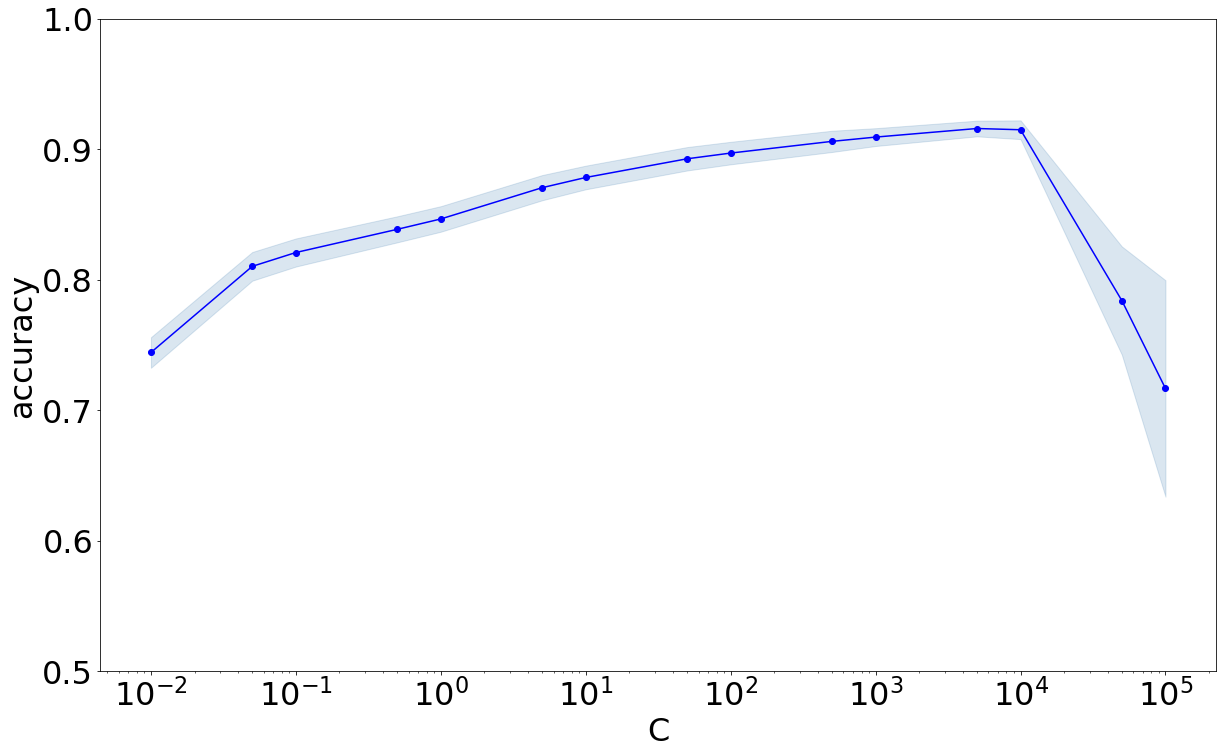

In [15]:
from sklearn import svm


def choose_hyperparameters(X_train, y_train):
    C_tuple = (0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 1e4, 5e4, 1e5)
    kernels = ('rbf',)
    
    for curr_kernel in kernels:
        accuracies = []
        deviations = []
        for curr_C in C_tuple:
            curr_svm_classifier = svm.SVC(
                C=curr_C,
                kernel=curr_kernel,
                degree=2,
                coef0=0.0,
                cache_size=2000,
                max_iter=250000
            )
            curr_tns_df, curr_fps_df, curr_fns_df, curr_tps_df = (
                test_classifier(curr_svm_classifier, X_train, y_train)
            )

            curr_accuracies = []
            for i in range(T*Q):
                curr_tn_rate = curr_tns_df.at[i, 'tn_rate']
                curr_fp_rate = curr_fps_df.at[i, 'fp_rate']
                curr_fn_rate = curr_fns_df.at[i, 'fn_rate']
                curr_tp_rate = curr_tps_df.at[i, 'tp_rate']
                curr_accuracies.append(
                    (curr_tp_rate + curr_tn_rate)/
                    (curr_tp_rate + curr_tn_rate + curr_fp_rate + curr_fn_rate)
                )
            curr_avg_accuracy = sum(curr_accuracies)/len(curr_accuracies)
            accuracies.append(curr_avg_accuracy)
            deviations.append(np.array(curr_accuracies).std()*2)
            print(
                'curr_C =', curr_C,
                '; curr_avg_accuracy =', curr_avg_accuracy,
                '; curr_kernel =', curr_kernel
            )
        make_plot(accuracies, deviations, C_tuple, curr_kernel)


choose_hyperparameters(X_train, y_train)

### К этому моменту мы настроили гиперпараметры и отобрали признаки!

Теперь нужно указать подобранные гиперпараметры в качестве следующих констант:
* BEST_C        --- штраф за принятие неверного решения
* BEST_PENALTY  --- регуляризатор ('l1' или 'l2')
* BEST_FEATURES --- индексы колонок с отобранными признаками

In [16]:
BEST_C = 5000
BEST_KERNEL = 'rbf'
# BEST_PENALTY = 'l1'

Создадим объект классификатора с настроенными гиперпараметрами:

In [17]:
from sklearn import svm

svm_classifier = svm.SVC(
    C=BEST_C,
    kernel=BEST_KERNEL,
    degree=2,
    coef0=0.0,
    cache_size=2000,
    max_iter=250000
)

Обучим классификатор на обучающей выборке (X_train, y_train):

In [18]:
svm_classifier.fit(X_train, y_train)

/home/artem/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=5000, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=250000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### На данном этапе процесс обучения завершён!

Сохраним классификатор на диск.

In [19]:
from sklearn.externals import joblib
joblib.dump(svm_classifier, '../results/svm/svm_classifier.pkl')

['../results/svm/svm_classifier.pkl']